# Assignment 2: Conditional GAN for Bird Image Generation

**Objective**: Build a conditional Generative Adversarial Network (cGAN) to generate 64x64 bird images from attribute descriptions.

**Dataset**: CUB-200-2011 (5-class subset)
- Black_footed_Albatross
- Red_faced_Cormorant
- Bobolink
- Lazuli_Bunting
- Yellow_breasted_Chat

## 1. Setup and Configuration

### 1.1 Import Libraries

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid, save_image
from PIL import Image

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

### 1.2 Reproducibility Configuration

In [3]:
SEED = 42

def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    print(f'Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB')

Using device: cuda
GPU: NVIDIA GeForce RTX 5070 Ti Laptop GPU
Memory: 11.94 GB


### 1.3 Hyperparameters and Paths

In [4]:
DATA_ROOT = 'CUB_200_2011'
MODEL_DIR = 'models'
OUTPUT_DIR = 'outputs'
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, 'generated_samples'), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, 'evaluation_images'), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, 'training_progress'), exist_ok=True)

TARGET_CLASSES = [
    'Black_footed_Albatross',
    'Red_faced_Cormorant',
    'Bobolink',
    'Lazuli_Bunting',
    'Yellow_breasted_Chat'
]

IMG_SIZE = 64
BATCH_SIZE = 16
LATENT_DIM = 100
NUM_EPOCHS = 100
LR_G = 0.0002
LR_D = 0.0002
BETA1 = 0.5
BETA2 = 0.999
LABEL_SMOOTHING = 0.1

## 2. Data Exploration and Analysis

### 2.1 Load Dataset Metadata

In [15]:
images_df = pd.read_csv(
    os.path.join(DATA_ROOT, 'images.txt'),
    sep=' ',
    names=['image_id', 'image_path']
)

labels_df = pd.read_csv(
    os.path.join(DATA_ROOT, 'image_class_labels.txt'),
    sep=' ',
    names=['image_id', 'class_id']
)

split_df = pd.read_csv(
    os.path.join(DATA_ROOT, 'train_test_split.txt'),
    sep=' ',
    names=['image_id', 'is_training']
)

classes_df = pd.read_csv(
    os.path.join(DATA_ROOT, 'classes.txt'),
    sep=' ',
    names=['class_id', 'class_name']
)
classes_df['class_name'] = classes_df['class_name'].str.split('.', n=1).str[1]

attributes_list = pd.read_csv(
    os.path.join(DATA_ROOT, 'attributes', 'attributes.txt'),
    sep=' ',
    names=['attribute_id', 'attribute_name']
)
attributes_list['attribute_name'] = attributes_list['attribute_name'].str.split('::', n=1).str[1]

image_attributes = pd.read_csv(
    os.path.join(DATA_ROOT, 'attributes', 'image_attribute_labels.txt'),
    sep=r'\s+',
    names=['image_id', 'attribute_id', 'is_present', 'certainty_id', 'time'],
    usecols=[0, 1, 2, 3, 4],
    on_bad_lines='skip',
    engine='python'
)

### 2.2 Filter Target Classes

In [16]:
target_class_ids = classes_df[classes_df['class_name'].isin(TARGET_CLASSES)]['class_id'].values
class_id_to_name = dict(zip(classes_df['class_id'], classes_df['class_name']))
class_name_to_id = {name: idx for idx, name in enumerate(TARGET_CLASSES)}
class_id_to_label = {cid: class_name_to_id[class_id_to_name[cid]] for cid in target_class_ids}

filtered_df = images_df.merge(labels_df, on='image_id').merge(split_df, on='image_id')
filtered_df = filtered_df[filtered_df['class_id'].isin(target_class_ids)]
filtered_df['label'] = filtered_df['class_id'].map(class_id_to_label)

train_df = filtered_df[filtered_df['is_training'] == 1].reset_index(drop=True)
test_df = filtered_df[filtered_df['is_training'] == 0].reset_index(drop=True)

print(f'Total images: {len(filtered_df)}')
print(f'Training images: {len(train_df)}')
print(f'Test images: {len(test_df)}')

Total images: 289
Training images: 150
Test images: 139


### 2.3 Class Distribution

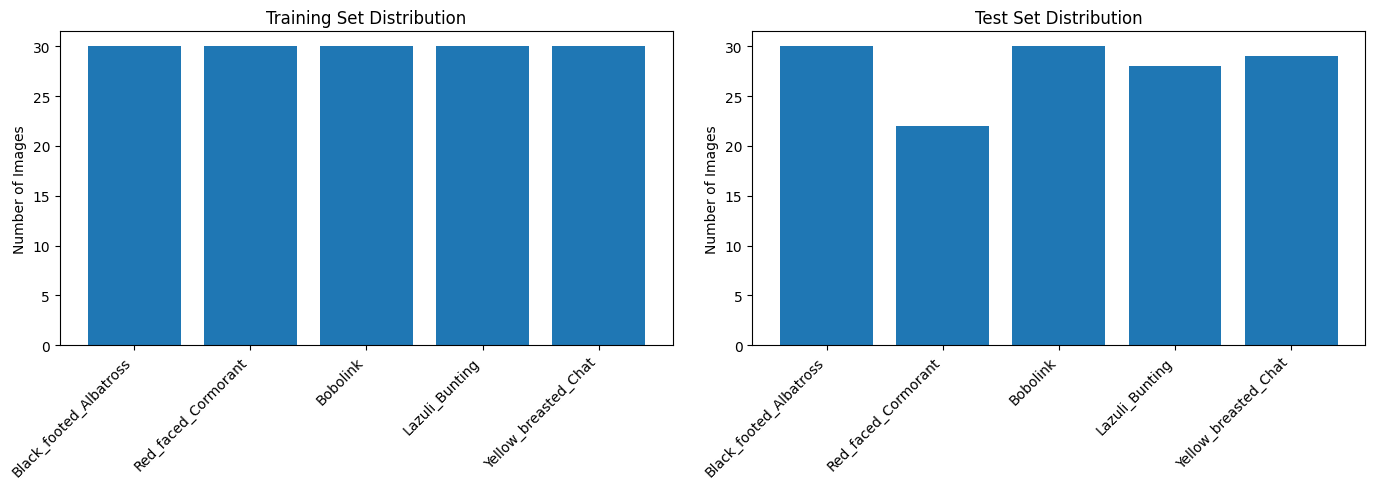

In [17]:
train_class_counts = train_df['label'].value_counts().sort_index()
test_class_counts = test_df['label'].value_counts().sort_index()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].bar(range(len(TARGET_CLASSES)), train_class_counts.values)
axes[0].set_xticks(range(len(TARGET_CLASSES)))
axes[0].set_xticklabels(TARGET_CLASSES, rotation=45, ha='right')
axes[0].set_title('Training Set Distribution')
axes[0].set_ylabel('Number of Images')

axes[1].bar(range(len(TARGET_CLASSES)), test_class_counts.values)
axes[1].set_xticks(range(len(TARGET_CLASSES)))
axes[1].set_xticklabels(TARGET_CLASSES, rotation=45, ha='right')
axes[1].set_title('Test Set Distribution')
axes[1].set_ylabel('Number of Images')

plt.tight_layout()
plt.show()

### 2.4 Attribute Statistics

In [18]:
print(f'Total number of attributes: {len(attributes_list)}')
print(f'Total attribute annotations: {len(image_attributes)}')
print(f'\nCertainty levels:')
print(image_attributes['certainty_id'].value_counts().sort_index())
print(f'\nAttribute presence:')
print(image_attributes['is_present'].value_counts())

Total number of attributes: 312
Total attribute annotations: 3677856

Certainty levels:
certainty_id
1     394906
2     228021
3    1021155
4    2033774
Name: count, dtype: int64

Attribute presence:
is_present
0    3306809
1     371047
Name: count, dtype: int64


## 3. Part 1: Attribute Data Processing

### 3.1 Build Attribute Vectors

In [20]:
def build_attribute_vector(image_id, attr_df, num_attributes=312, use_certainty=True):
    img_attrs = attr_df[attr_df['image_id'] == image_id]
    attr_vector = np.zeros(num_attributes)
    
    for _, row in img_attrs.iterrows():
        attr_idx = int(row['attribute_id']) - 1
        if row['is_present'] == 1:
            if use_certainty:
                attr_vector[attr_idx] = row['certainty_id'] / 4.0
            else:
                attr_vector[attr_idx] = 1.0
    
    return attr_vector

train_attributes = {}
for img_id in train_df['image_id']:
    train_attributes[img_id] = build_attribute_vector(img_id, image_attributes, use_certainty=True)

test_attributes = {}
for img_id in test_df['image_id']:
    test_attributes[img_id] = build_attribute_vector(img_id, image_attributes, use_certainty=True)

print(f'Built attribute vectors for {len(train_attributes)} training images')
print(f'Built attribute vectors for {len(test_attributes)} test images')
print(f'Attribute vector dimension: {len(train_attributes[train_df.iloc[0]["image_id"]])}')

Built attribute vectors for 150 training images
Built attribute vectors for 139 test images
Attribute vector dimension: 312


### 3.2 Attribute Vector Analysis

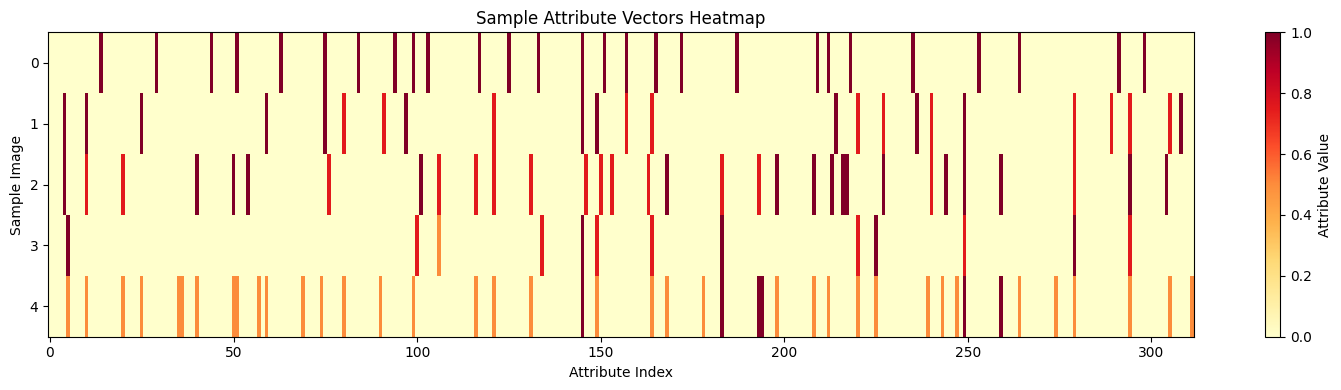

Attribute vector sparsity: 90.40%
Average non-zero attributes per image: 29.9


In [21]:
sample_vectors = np.array([train_attributes[img_id] for img_id in list(train_attributes.keys())[:5]])

plt.figure(figsize=(15, 4))
plt.imshow(sample_vectors, aspect='auto', cmap='YlOrRd')
plt.colorbar(label='Attribute Value')
plt.xlabel('Attribute Index')
plt.ylabel('Sample Image')
plt.title('Sample Attribute Vectors Heatmap')
plt.tight_layout()
plt.show()

all_train_vectors = np.array(list(train_attributes.values()))
attr_sparsity = (all_train_vectors == 0).sum() / all_train_vectors.size
print(f'Attribute vector sparsity: {attr_sparsity:.2%}')
print(f'Average non-zero attributes per image: {(all_train_vectors > 0).sum(axis=1).mean():.1f}')

### 3.3 Dataset Class

In [22]:
class BirdAttributeDataset(Dataset):
    def __init__(self, df, attributes_dict, data_root, transform=None):
        self.df = df
        self.attributes_dict = attributes_dict
        self.data_root = data_root
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.data_root, 'images', row['image_path'])
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        attr_vector = torch.FloatTensor(self.attributes_dict[row['image_id']])
        label = row['label']
        
        return image, attr_vector, label

### 3.4 Data Transforms and Loaders

In [23]:
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = BirdAttributeDataset(train_df, train_attributes, DATA_ROOT, transform=transform)
test_dataset = BirdAttributeDataset(test_df, test_attributes, DATA_ROOT, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f'Training batches: {len(train_loader)}')
print(f'Test batches: {len(test_loader)}')

Training batches: 10
Test batches: 9


### 3.5 Visualize Sample Data

In [ ]:
# sample_images, sample_attrs, sample_labels = next(iter(train_loader))

# fig, axes = plt.subplots(2, 4, figsize=(12, 6))
# for i in range(8):
#     ax = axes[i // 4, i % 4]
#     img = sample_images[i].permute(1, 2, 0).numpy()
#     img = (img + 1) / 2
#     ax.imshow(img)
#     ax.set_title(TARGET_CLASSES[sample_labels[i]])
#     ax.axis('off')
# plt.tight_layout()
# plt.show()

## 4. Part 2: Conditional GAN Training

### 4.1 Generator Architecture

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100, attr_dim=312, img_channels=3):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.attr_dim = attr_dim
        
        self.fc = nn.Sequential(
            nn.Linear(latent_dim + attr_dim, 256 * 4 * 4),
            nn.BatchNorm1d(256 * 4 * 4),
            nn.ReLU(True)
        )
        
        self.conv_blocks = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(32, img_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    
    def forward(self, noise, attributes):
        x = torch.cat([noise, attributes], dim=1)
        x = self.fc(x)
        x = x.view(x.size(0), 256, 4, 4)
        x = self.conv_blocks(x)
        return x

### 4.2 Discriminator Architecture

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, attr_dim=312, img_channels=3, img_size=64):
        super(Discriminator, self).__init__()
        self.attr_dim = attr_dim
        self.img_size = img_size
        
        self.conv_blocks = nn.Sequential(
            nn.Conv2d(img_channels, 32, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(32, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        self.fc = nn.Sequential(
            nn.Linear(256 * 4 * 4 + attr_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )
    
    def forward(self, img, attributes):
        x = self.conv_blocks(img)
        x = x.view(x.size(0), -1)
        x = torch.cat([x, attributes], dim=1)
        x = self.fc(x)
        return x

### 4.3 Initialize Models

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

generator = Generator(latent_dim=LATENT_DIM, attr_dim=312).to(device)
discriminator = Discriminator(attr_dim=312, img_size=IMG_SIZE).to(device)

generator.apply(weights_init)
discriminator.apply(weights_init)

print('Generator:')
print(generator)
print(f'\nGenerator parameters: {sum(p.numel() for p in generator.parameters()):,}')
print(f'\nDiscriminator parameters: {sum(p.numel() for p in discriminator.parameters()):,}')

### 4.4 Loss Functions and Optimizers

In [ ]:
criterion = nn.BCELoss()

optimizer_G = optim.Adam(generator.parameters(), lr=LR_G, betas=(BETA1, BETA2))
optimizer_D = optim.Adam(discriminator.parameters(), lr=LR_D, betas=(BETA1, BETA2))

scheduler_G = optim.lr_scheduler.StepLR(optimizer_G, step_size=30, gamma=0.5)
scheduler_D = optim.lr_scheduler.StepLR(optimizer_D, step_size=30, gamma=0.5)

### 4.5 Training Loop

In [ ]:
def train_gan(generator, discriminator, train_loader, num_epochs, device):
    g_losses = []
    d_losses = []
    
    fixed_noise = torch.randn(16, LATENT_DIM, device=device)
    sample_batch = next(iter(train_loader))
    fixed_attrs = sample_batch[1][:16].to(device)
    
    for epoch in range(num_epochs):
        generator.train()
        discriminator.train()
        
        epoch_g_loss = 0
        epoch_d_loss = 0
        
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        for real_imgs, attributes, _ in pbar:
            batch_size = real_imgs.size(0)
            real_imgs = real_imgs.to(device)
            attributes = attributes.to(device)
            
            real_labels = torch.ones(batch_size, 1, device=device) * (1 - LABEL_SMOOTHING)
            fake_labels = torch.zeros(batch_size, 1, device=device)
            
            optimizer_D.zero_grad()
            
            real_output = discriminator(real_imgs, attributes)
            d_loss_real = criterion(real_output, real_labels)
            
            noise = torch.randn(batch_size, LATENT_DIM, device=device)
            fake_imgs = generator(noise, attributes)
            fake_output = discriminator(fake_imgs.detach(), attributes)
            d_loss_fake = criterion(fake_output, fake_labels)
            
            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            optimizer_D.step()
            
            optimizer_G.zero_grad()
            
            noise = torch.randn(batch_size, LATENT_DIM, device=device)
            fake_imgs = generator(noise, attributes)
            fake_output = discriminator(fake_imgs, attributes)
            g_loss = criterion(fake_output, real_labels)
            
            g_loss.backward()
            optimizer_G.step()
            
            epoch_g_loss += g_loss.item()
            epoch_d_loss += d_loss.item()
            
            pbar.set_postfix({
                'D_loss': f'{d_loss.item():.4f}',
                'G_loss': f'{g_loss.item():.4f}'
            })
        
        avg_g_loss = epoch_g_loss / len(train_loader)
        avg_d_loss = epoch_d_loss / len(train_loader)
        g_losses.append(avg_g_loss)
        d_losses.append(avg_d_loss)
        
        scheduler_G.step()
        scheduler_D.step()
        
        if (epoch + 1) % 10 == 0:
            generator.eval()
            with torch.no_grad():
                fake_samples = generator(fixed_noise, fixed_attrs)
                save_image(
                    fake_samples,
                    os.path.join(OUTPUT_DIR, 'training_progress', f'epoch_{epoch+1}.png'),
                    nrow=4,
                    normalize=True
                )
            
            torch.save({
                'epoch': epoch,
                'generator_state_dict': generator.state_dict(),
                'discriminator_state_dict': discriminator.state_dict(),
                'optimizer_G_state_dict': optimizer_G.state_dict(),
                'optimizer_D_state_dict': optimizer_D.state_dict(),
            }, os.path.join(MODEL_DIR, f'checkpoint_epoch_{epoch+1}.pt'))
        
        print(f'Epoch [{epoch+1}/{num_epochs}] - D_loss: {avg_d_loss:.4f}, G_loss: {avg_g_loss:.4f}')
    
    return g_losses, d_losses

### 4.6 Train the Model

In [ ]:
g_losses, d_losses = train_gan(generator, discriminator, train_loader, NUM_EPOCHS, device)

### 4.7 Save Final Models

In [ ]:
torch.save(generator.state_dict(), os.path.join(MODEL_DIR, 'generator_best.pt'))
torch.save(discriminator.state_dict(), os.path.join(MODEL_DIR, 'discriminator_best.pt'))
print('Models saved successfully!')

### 4.8 Training Loss Curves

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(g_losses, label='Generator Loss', alpha=0.8)
plt.plot(d_losses, label='Discriminator Loss', alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GAN Training Losses')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'loss_curves.png'), dpi=300, bbox_inches='tight')
plt.show()

## 5. Part 3: Model Evaluation [20 marks]

### 5.1 (i) Qualitative Evaluation

#### Select 5 Distinct Attribute Combinations

In [ ]:
generator.eval()

selected_attrs = []
selected_labels = []
for class_idx in range(5):
    class_df = train_df[train_df['label'] == class_idx]
    sample_img_id = class_df.sample(1).iloc[0]['image_id']
    selected_attrs.append(train_attributes[sample_img_id])
    selected_labels.append(class_idx)

selected_attrs = torch.FloatTensor(np.array(selected_attrs)).to(device)

with torch.no_grad():
    noise = torch.randn(5, LATENT_DIM, device=device)
    generated_samples = generator(noise, selected_attrs)

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    img = generated_samples[i].cpu().permute(1, 2, 0).numpy()
    img = (img + 1) / 2
    img = np.clip(img, 0, 1)
    axes[i].imshow(img)
    axes[i].set_title(TARGET_CLASSES[selected_labels[i]])
    axes[i].axis('off')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'generated_samples', 'qualitative_samples.png'), dpi=300, bbox_inches='tight')
plt.show()

### 5.2 (ii) Quantitative Evaluation with Assignment 1 Classifier

#### Load Assignment 1 CNN Model

In [ ]:
class BirdCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(BirdCNN, self).__init__()
        
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.block4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512 * 7 * 7, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

classifier = BirdCNN(num_classes=5).to(device)
classifier.load_state_dict(torch.load(os.path.join(MODEL_DIR, 'best_bird_cnn.pt'), map_location=device))
classifier.eval()
print('Assignment 1 classifier loaded successfully!')

#### Generate 50 Synthetic Images (10 per class)

In [ ]:
generator.eval()

synthetic_images = []
synthetic_labels = []

for class_idx in range(5):
    class_df = train_df[train_df['label'] == class_idx]
    sampled_imgs = class_df.sample(min(10, len(class_df)))
    
    class_dir = os.path.join(OUTPUT_DIR, 'evaluation_images', f'class_{class_idx}')
    os.makedirs(class_dir, exist_ok=True)
    
    for i, (_, row) in enumerate(sampled_imgs.iterrows()):
        attr_vector = torch.FloatTensor(train_attributes[row['image_id']]).unsqueeze(0).to(device)
        
        with torch.no_grad():
            noise = torch.randn(1, LATENT_DIM, device=device)
            fake_img = generator(noise, attr_vector)
        
        save_image(
            fake_img,
            os.path.join(class_dir, f'img_{i}.png'),
            normalize=True
        )
        
        synthetic_images.append(fake_img)
        synthetic_labels.append(class_idx)

print(f'Generated {len(synthetic_images)} synthetic images')

#### Classify Synthetic Images

In [ ]:
classifier_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

predictions = []
classifier.eval()

with torch.no_grad():
    for img in synthetic_images:
        img_224 = transforms.functional.resize(img, (224, 224))
        output = classifier(img_224)
        pred = output.argmax(dim=1).item()
        predictions.append(pred)

predictions = np.array(predictions)
true_labels = np.array(synthetic_labels)

accuracy = (predictions == true_labels).mean()
print(f'Classification Accuracy on Generated Images: {accuracy:.4f}')

#### Confusion Matrix

In [ ]:
cm = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=TARGET_CLASSES)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix: Generated Images Classification')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'confusion_matrix.png'), dpi=300, bbox_inches='tight')
plt.show()

#### Classification Report

In [ ]:
report = classification_report(true_labels, predictions, target_names=TARGET_CLASSES, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print(report_df)

### 5.3 Discussion Section

## 6. Model Deployment

### 6.1 Standalone Generation Function

In [ ]:
def test_single(attribute_vector, model_path='models/generator_best.pt', latent_dim=100, seed=42):
    
    import torch
    import torch.nn as nn
    import numpy as np
    
    class Generator(nn.Module):
        def __init__(self, latent_dim=100, attr_dim=312, img_channels=3):
            super(Generator, self).__init__()
            self.latent_dim = latent_dim
            self.attr_dim = attr_dim
            
            self.fc = nn.Sequential(
                nn.Linear(latent_dim + attr_dim, 256 * 4 * 4),
                nn.BatchNorm1d(256 * 4 * 4),
                nn.ReLU(True)
            )
            
            self.conv_blocks = nn.Sequential(
                nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
                nn.BatchNorm2d(128),
                nn.ReLU(True),
                
                nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
                nn.BatchNorm2d(64),
                nn.ReLU(True),
                
                nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),
                nn.BatchNorm2d(32),
                nn.ReLU(True),
                
                nn.ConvTranspose2d(32, img_channels, 4, 2, 1, bias=False),
                nn.Tanh()
            )
        
        def forward(self, noise, attributes):
            x = torch.cat([noise, attributes], dim=1)
            x = self.fc(x)
            x = x.view(x.size(0), 256, 4, 4)
            x = self.conv_blocks(x)
            return x
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    if isinstance(attribute_vector, np.ndarray):
        attribute_vector = torch.FloatTensor(attribute_vector)
    elif not isinstance(attribute_vector, torch.Tensor):
        attribute_vector = torch.FloatTensor(attribute_vector)
    
    if attribute_vector.dim() == 1:
        attribute_vector = attribute_vector.unsqueeze(0)
    
    attribute_vector = attribute_vector.to(device)
    
    generator = Generator(latent_dim=latent_dim, attr_dim=attribute_vector.size(1)).to(device)
    generator.load_state_dict(torch.load(model_path, map_location=device))
    generator.eval()
    
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
    
    with torch.no_grad():
        noise = torch.randn(1, latent_dim, device=device)
        generated_image = generator(noise, attribute_vector)
    
    generated_image = generated_image.squeeze(0)
    generated_image = (generated_image + 1) / 2
    generated_image = torch.clamp(generated_image, 0, 1)
    
    return generated_image

### 6.2 Test the Function

In [ ]:
test_img_id = train_df.sample(1).iloc[0]['image_id']
test_attr = train_attributes[test_img_id]

generated = test_single(test_attr)

plt.figure(figsize=(4, 4))
plt.imshow(generated.cpu().permute(1, 2, 0).numpy())
plt.title('Generated Image from test_single')
plt.axis('off')
plt.tight_layout()
plt.show()

print(f'Output shape: {generated.shape}')
print(f'Output range: [{generated.min():.3f}, {generated.max():.3f}]')

## 7. Summary and Deliverables

### 7.1 Part 1 Deliverables

### 7.2 Part 2 Deliverables

### 7.3 Part 3 Deliverables